# 1. Intro

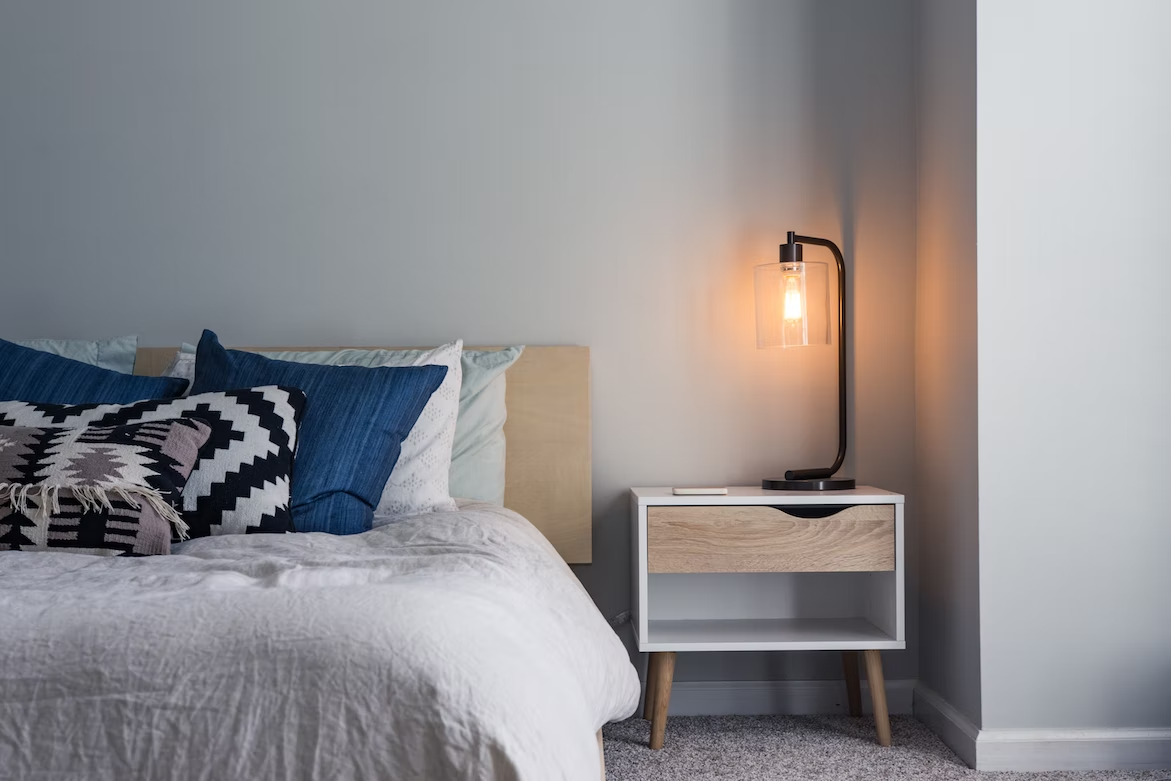

안녕하세요 ! Stage 5에 오신 데이커 여러분들을 환영합니다 👋👋👋



Stage 4에서는 의사결정 나무, 랜덤포레스트 모델과 모델 성능 평가 방법을 배웠습니다.

혹시 복습하신 분 있으신가요? 최고 👍👍



Stage 5에서는 성능이 좋다고 알려진 부스팅 모델과 Pycaret에 대해 알아보겠습니다. 



이제 얼마 안 남았네요 😄 Stage 5도 모두 화이팅 해봐요! 🔥🔥🔥

---

# 2. 데이터 전처리

모델의 성능을 비교하기 위해 데이터 전처리는 필수랍니다 !

벌써 두 번이나 해봤으니, 쉽게 하실 수 있겠죠? 자~ 들어갑니다! 🚗

In [ ]:
# 주피터라이트에서 seaborn 사용하기
import micropip
await micropip.install('seaborn')

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# train 데이터를 불러옵니다
train = pd.read_csv('./train.csv')

In [2]:
# 평당 아파트 실거래가 파생변수를 생성합니다.
train['price_per_area'] = train['transaction_real_price'] / train['exclusive_use_area']*3.3

# 아파트 연식 변수를 생성합니다.
train['year'] = train['transaction_year_month'].astype(str).str[:4].astype(int)
train['month'] = train['transaction_year_month'].astype(str).str[4:].astype(int)

# 거래일
train.loc[(train['transaction_date'] == '21~30') | (train['transaction_date'] == '21~28') | (train['transaction_date'] == '21~29'), 'transaction_date'] = '21~31'

# 아파트 연식
train['age'] = train['year'] - train['year_of_completion']

# 재건축여부
train.loc[train['age'] < 20, 'reconstruction'] = 'NO'
train.loc[train['age'] >= 20, 'reconstruction'] = 'YES'

In [3]:
# re 모듈을 선언하고 괄호와 괄호 안 문자를 찾아서 삭제합니다.
from tqdm import tqdm
import time
import re

regex = "\(.*\)"

for i in tqdm(range(len(train))):
   train.at[i, 'apt'] = re.sub(regex, '', train.at[i, 'apt']) 

100%|█████████████████████████████████████████████████████████████████████| 1216553/1216553 [00:31<00:00, 38455.26it/s]


In [4]:
# 상위 20개 아파트 이름 리스트를 생성합니다.
apt_brand_list = train['apt'].value_counts()[:20].index

# 상위 20개 아파트 이름에 속하는지를 구별하는 변수를 생성합니다.
train['branded'] = False

# 아파트 이름이 리스트 안의 브랜드를 가지고 있다면 대표 이름으로 바꿔고 branded 변수를 True로 바꿉니다.
for brand in tqdm(apt_brand_list):
  train['apt'].loc[train['apt'].str.contains(brand)] = brand
  train['branded'].loc[train['apt'].str.contains(brand)] = True

# branded 변수가 False인 아파트를 others라는 이름으로 통합합니다.
train['apt'].loc[~train['branded']] = 'others'

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]C:\Users\USER\AppData\Local\Temp\ipykernel_5040\2881525954.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['apt'].loc[train['apt'].str.contains(brand)] = brand
C:\Users\USER\AppData\Local\Temp\ipykernel_5040\2881525954.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['branded'].loc[train['apt'].str.contains(brand)] = True
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:31<00:00,  1.56s/it]
C:\Users\USER\AppData\Local\Temp\ipykernel_

In [5]:
# 평단가 평균을 기준으로 아파트명을 오름차순 정렬해줍니다. 
apt_price = train.groupby('apt')['price_per_area'].mean().sort_values(ascending=True)

# 평단가 평균이 낮은 순으로 아파트명에 0부터 19까지 부여해줍니다.
for i, apt in enumerate(tqdm(apt_price.index)):
    train['apt'].loc[train['apt'] == apt] = i

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]C:\Users\USER\AppData\Local\Temp\ipykernel_5040\689223827.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['apt'].loc[train['apt'] == apt] = i
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.67it/s]


In [6]:
# object 타입이기 때문에 이를 int64 형태로 변경합니다.
train.loc[:,'apt'] = train.loc[:,'apt'].astype('int')

In [7]:
# 로그변환
train['transaction_real_price'] = np.log1p(train['transaction_real_price'])

# 이상치 제거
train  = train.loc[train['price_per_area']>= 200, :]

In [8]:
# 범주형 변수와 수치형 변수로 분리
train_X_cat = train[['city','transaction_date', 'reconstruction']]
train_X_num = train[['exclusive_use_area','floor', 'age']]

In [9]:
# 라벨인코딩
le = LabelEncoder()
train_X_cat.loc[:,'city'] = le.fit_transform(train_X_cat.loc[:,'city'])
train_X_cat.loc[:,'transaction_date'] = le.fit_transform(train_X_cat.loc[:,'transaction_date'])
train_X_cat.loc[:,'reconstruction'] = le.fit_transform(train_X_cat.loc[:,'reconstruction'])

C:\Users\USER\AppData\Local\Temp\ipykernel_5040\1386556571.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X_cat.loc[:,'city'] = le.fit_transform(train_X_cat.loc[:,'city'])
C:\Users\USER\AppData\Local\Temp\ipykernel_5040\1386556571.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X_cat.loc[:,'transaction_date'] = le.fit_transform(train_X_cat.loc[:,'transaction_date'])
C:\Users\USER\AppData\Local\Temp\ipykernel_5040\1386556571.py:5: SettingWithCopyWarning: 
A value is trying to be set on a

In [10]:
# 정규화 
minmax_scaler = MinMaxScaler()
train_minmax = minmax_scaler.fit_transform(train_X_num)
train_minmax = pd.DataFrame(train_minmax, index=train_X_num.index, columns=train_X_num.columns)

In [11]:
# 라벨인코딩과 정규화가 완료된 데이터 합치기
X = pd.concat([train_minmax, train_X_cat, train['apt']], axis=1)

In [12]:
# 예측해야 할 변수를 y라는 객체에 따로 저장합니다.
y = train['transaction_real_price']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

데이터 준비가 완료되었어요 😙😙

이제 실습을 시작해볼까요? 💖

---

# 3. 부스팅(Boosting)

Stage4에서 배깅(Bagging)기반의 앙상블 기법이 무엇인지 배웠고, <br>
그보다 더 발전된 방법인 <font color=purple>**랜덤포레스트(RandomForest)**</font>에 대해 배웠는데요. (다 같이 복습 복습! ✏️✏️

stage5 에서는 배깅과는 또 다른 앙상블 기법인 부스팅(Boosting) 기반의 모델들을 배워보겠습니다.

<font color=red>**부스팅(Boosting)**</font>이란 약한 학습기(weak learner)가 순차적으로 학습을 수행하되, <br>
잘못 예측한 데이터에 대해 높은 <font color=green>**가중치**</font>를 두어 다음 학습기에서 오류를 개선해 나가는 학습 방법입니다.


여기서 <font color=blue>약한 학습기(weak learner)</font>란 무작위로 선택하는 것 보다 약간 성능이 더 좋은 모델을 의미하며, <br>
주로 깊이가 낮은 의사결정 나무(Decision Tree)를 약한 학습기로 사용합니다.

## 3.1 AdaBoost

이러한 부스팅 기법을 사용하는 대표적인 모델에는 Adaboost가 있습니다. 

<font color=red>**AdaBoost**</font>는 이전 모형에서 <font color=blue>오차가 큰 데이터(혹은 오분류된 데이터)</font>에 더 집중하여 약점을 보완하는 대표적인 부스팅 기법의 모델이에요.

AdaBoost의 원리를 이해하는 데에는 분류 모형이 더 직관적이기 때문에, 분류 모형을 통해 AdaBoost의 원리를 알아보겠습니다.

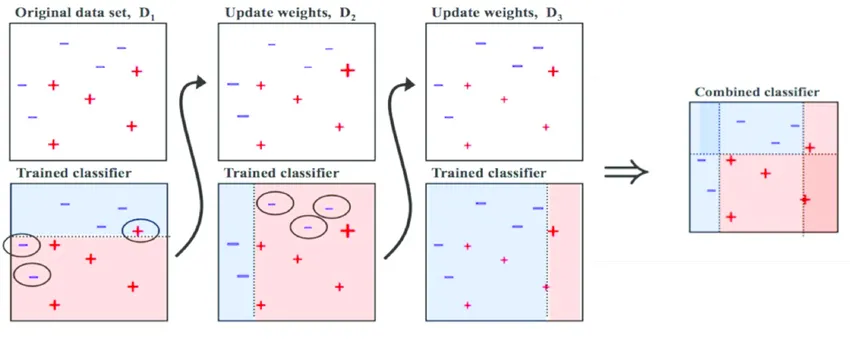

>출처: https://towardsdatascience.com/understanding-adaboost-for-decision-tree-ff8f07d2851

여기서 보이는 모델들은 <font color=purple>노드를 하나만 가진 의사결정 나무</font>입니다. 

즉, 약한 학습기(weak learner)로 노드를 하나만 가지는 의사결정 나무를 선택했습니다. 

weak learner **3개**를 사용하여 Adaboost를 만든다고 가정하면 **원리**는 다음과 같습니다.

① Model 1에서 <font color=green>⭕동그라미친 데이터⭕</font>는 <font color=blue>weak learner1이 ❌잘못 예측한 데이터들❌</font>입니다.
* Model 2에서 해당 데이터들의 크기가 커진 것을 볼 수 있습니다 😳
* 이처럼 weak learner 1이 잘못 예측한 데이터를 **다음 모델인 weak learner 2가 잘 예측하도록 가중치를 부여**합니다.
* 이를 통해 weak learner 2는 **잘못 예측한 데이터를 분류하는데 더 집중**하게 됩니다.

② 다음으로 weak learner 3는 <font color=blue>weak learner 1, 2가 ❌잘못 예측한 데이터❌를 더 잘 예측하도록 가중치를 부여</font>합니다.
* 이를 통해, weak learner 3는 weak learner 1, 2가 **잘못 예측한 데이터를 분류하는데 더 집중**하게 됩니다. 

③ 이를 바탕으로 3개 모델의 <font color=green>**가중치**</font>를 계산하고 이를 반영하여 최종 모델을 생성합니다.

배깅과의 차이점이 보이시나요?


부스팅 기법은 배깅과 달리 각각의 모델을 <font color=purple>**순차적**</font>으로 적용하는게 가장 큰 특징입니다.




---

### AdaBoost의 하이퍼파라미터

Adaboost도 다른 모델들처럼 여러 하이퍼파라미터가 있는데요. <br>
자주 사용하는 하이퍼파라미터를 알아볼게요 🙂

- base_estimator : 학습시 사용하는 약한 학습기의 종류를 의미합니다.

  설정하지 않으면 기본값은 깊이가 1인 의사결정나무가 사용됩니다.

- learning_rate : 약한 학습기가 순차적으로 오류값을 보정해나갈 때 적용하는 계수를 의미합니다.

  <font color=green>얼마나 강하게 오류를 보정할 것인지</font>를 결정한다고 생각하면 되겠습니다.
  
  값이 작을수록 천천히 진행하는 세밀한 모델이 되지만 속도가 느리다는 단점이 존재합니다.
  
  반면에 값이 크면 속도는 빠르지만 디테일한 부분을 놓칠 수 있습니다. 따라서 적절한 값을 선택하는 것이 중요합니다.

- n_estimators : 약한 학습기의 개수를 의미합니다.

  약한 학습기는 순차적으로 오류를 보정하기 때문에 그 수가 많을수록 일정 구간까지 모델의 성능이 높아집니다.
  
  하지만 많이 사용할수록 속도가 느려진다는 단점이 있습니다.

여기서 한 가지 ⚠️주의할 점⚠️이 있는데요

learning rate에 따라 약한 학습기가 오류를 보정하기 때문에 learning rate와 n_estimators는 서로 연관성이 큽니다.



따라서 learning_rate를 변경한다면 이에 대응되는 적합한 약한 학습기의 개수를 선택해서 학습을 수행해야 한다는 점, 잊지 않기로 해요 우리! 💕

이제 실습을 진행하면서 원리를 이해해봅시다 😀 <br>

---

### AdaBoost 실습

sklearn 패키지에는 sklearn.ensemble에 `AdaBoostClassifier`, `AdaBoostRegressor`가 있습니다.

우리는 아파트 실거래가를 예측하는 <font color=green>회귀 문제</font>를 풀고 있기 때문에 <font color=orange>**AdaBoostRegressor**</font>를 불러와야 해요 🙂

In [14]:
from sklearn.ensemble import AdaBoostRegressor

이후 기존의 다른 모델들처럼 모델을 불러와 객체를 생성한 후, <font color=green>모델이름.fit(훈련할 독립변수, 훈련할 종속변수)</font>을 기입해주면 학습을 진행하게 됩니다.

모델을 불러올 때는 앞에서 말씀드린 하이퍼파라미터를 지정해줄 수 있는데요. 

이번에는 모두 default(기본)값을 사용해서 학습을 수행하겠습니다.

 다만, 매번 랜덤한 값이 뽑히지 않도록 `random_state` 값은 42로 고정할게요 📌📌📌

In [15]:
ad = AdaBoostRegressor(random_state = 42)

학습을 수행한 후, 우리가 만든 테스트 데이터를 넣어서 모델의 성능을 측정해볼 거에요.

성능의 척도로는 <font color=purple>**RMSE**</font>를 선택했습니다. RMSE 모두 기억하시죠? 😎

In [16]:
# RMSE
def RMSE(y_real,y_pred):
  return mean_squared_error(y_real, y_pred)**0.5

In [17]:
model_ad =  ad.fit(X_train, y_train)
ad_pred = model_ad.predict(X_test)

In [18]:
print('Adaboost Regression', RMSE(ad_pred,y_test))

Adaboost Regression 0.3821548250440165


AdaBoost 모델을 사용하니, RMSE 값이 약 0.3822 이군요!

---

### AdaBoost의 feature importance

AdaBoost 또한 랜덤포레스트처럼 <font color=orange>**fit된 모델.feature_importances_**</font>을 통해 각 칼럼들이 해당 모델에서 <font color=purple>얼마나 중요한지</font>를 수치로 보여줍니다. <br>
참 편리하죠? 👍

In [19]:
ad.feature_importances_

array([0.49159222, 0.05070986, 0.13745337, 0.27984125, 0.02054516,
       0.        , 0.01985812])

자 ~ 여기서 복습 들어갑니다 😎

Stage 4에서, feature_importances_를 통해 도출된 각각의 컬럼은 어떤 것을 의미한다고 배웠나요?


네, 그렇습니다 👏

각각은 <font color=purple>X 컬럼의 순서</font>대로 대응합니다.

그렇다면 X 컬럼이 어떤 순서로 되어있는지 확인해볼까요?

In [20]:
X.columns

Index(['exclusive_use_area', 'floor', 'age', 'city', 'transaction_date',
       'reconstruction', 'apt'],
      dtype='object')

오호라, <font color=green>**exclusive_use_area**</font>가 가장 중요한 변수였네요 👌

보통 feature importance를 통해 변수들의 중요도를 확인할 때는 그래프를 그려 한 눈에 볼 수 있게끔 만들어줍니다 😁

여기서는 seaborn 패키지를 이용해 가로로 된 <font color=blue>barplot</font>을 그려보겠습니다. 

이를 위해 먼저 `pd.DataFrame()`를 사용해서 데이터 프레임을 만들어보겠습니다. 

<font color=purple>index</font> 부분에는 <font color=purple>변수명</font>, <font color=purple>value</font> 부분에는 <font color=purple>변수 중요도</font> 값을 넣고 변수의 이름은 **feature importance**라고 하겠습니다. 

변수 이름을 지정하기 위해서는 `columns` 라는 인자를 사용합니다.

In [21]:
ad_feature_importance = pd.DataFrame(ad.feature_importances_, X.columns , columns =['feature importance'])

In [22]:
ad_feature_importance

,feature importance
exclusive_use_area,0.491592
floor,0.050710
age,0.137453
city,0.279841
transaction_date,0.020545
reconstruction,0.000000
apt,0.019858


또한 feature importance가 높은 순서대로 보기 위해서 먼저 데이터프레임을 내림차순으로 정렬해봅시다!

In [23]:
ad_feature_importance = ad_feature_importance.sort_values('feature importance', ascending = False)

자~ 이제 만들어진 데이터 프레임을 이용해서 그래프를 그려보겠습니다. 

우리 이미 Stage 2에서 그래프를 많이 그려봤으니, 이번에도 잘 할 수 있을 거예요 😄

그러니 퀴즈를 통해 seaborn을 이용해서 가로로 된 barplot을 스스로 그려봅시다 😊

자~ 시작해볼까요?

---

#### 퀴즈

In [ ]:
# seaborn의 barplot을 이용하여 변수의 중요도 순서대로 나타내봅시다.

plt.figure(figsize = (18,8))
sns.barplot( #### 괄호 안 코드를 채워주세요 #### )
plt.title('feature importance of adaboost', size = 20)

plt.xticks(size = 15)
plt.yticks(size = 15)

plt.xlabel('feature importance', size = 20)
plt.ylabel('column', size = 20)
plt.show()

SyntaxError: invalid syntax (409176890.py, line 7)

##### 설명

seaborn을 사용하여 변수 중요도를 가로 barplot으로 그려주세요!

##### 풀이 - 힌트

seaborn을 이용하여 가로로 된 barplot을 그릴 때는 <font color=orange>**orient='h'**</font>를 사용하면 됩니다.

##### 풀이-정답

```
# seaborn의 barplot을 이용하여 변수의 중요도 순서대로 나타내봅시다.

plt.figure(figsize = (18,8))
sns.barplot(x ='feature importance', y = ad_feature_importance.index ,orient='h', data = ad_feature_importance)
plt.title('feature importance of adaboost', size = 20)

plt.xticks(size = 15)
plt.yticks(size = 15)

plt.xlabel('feature importance', size = 20)
plt.ylabel('column', size = 20)
plt.show()
```

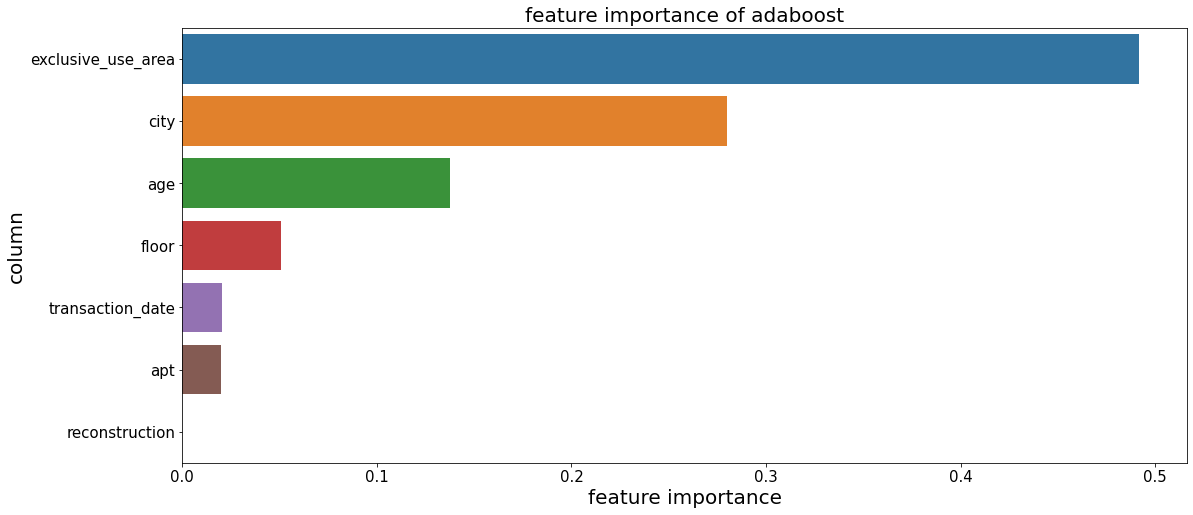

---

## 3.2 GBM(Gradient Boosting Machine)

다음으로 GBM에 대해 알아보겠습니다. GBM은 이름에서부터 그 의미를 내포하고 있답니다 😃

<font color=red>**GBM(Gradient Boosting Machine)**</font>은 AdaBoost와 유사하지만, <br>
가중치 업데이트를 <font color=blue>경사하강법(Gradient Descent)</font>을 이용하여 최적화된 결과를 얻는 방법론이에요. (아니 글쎄, 잠깐만요. 너무 어려운 거 아닌가요...? 😂)

여기서 <font color=blue>경사 하강법</font>이란, 실제값 y와 예측값 $\widehat{y}$ 사이의 <font color=green>오차가 최소</font>가 되도록 반복적으로 가중치 값을 업데이트하는 방식입니다.

가중치를 업데이트 할 때 해당 위치의 **미분값의 부호와 반대**로 가중치를 업데이트하는 것이 경사 하강법의 핵심 아이디어입니다!

예를 들어, 아래 사진처럼 현재 위치의 기울기는 음수입니다.

따라서 다음 위치로 가중치를 업데이트할 때는 이와 반대인 양수 방향으로 업데이트하게 됩니다.

경사하강법은 <font color=red>매우 중요한 개념</font>이니, 우리 3번, 아니 4번 읽고 넘어가요! ⭐⭐⭐

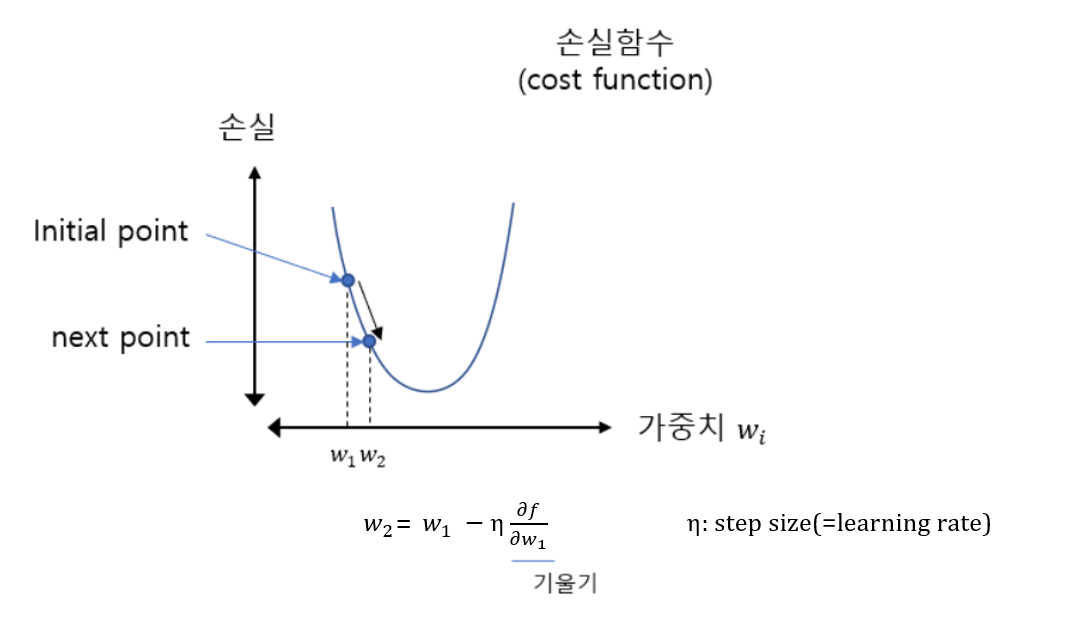

>출처 : https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=tinz6461&logNo=221589073944

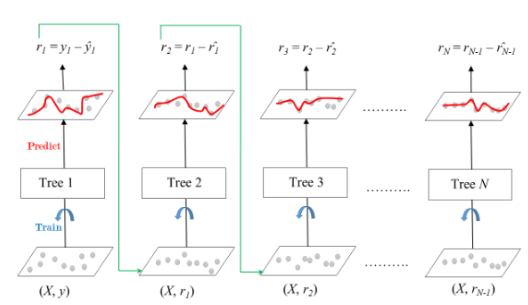

>출처 : https://www.geeksforgeeks.org/ml-gradient-boosting/

**GBM**은 경사하강법을 사용하기 때문에 Adaboost와 달리 **새로운 weak learner에 대해 새로운 학습데이터(x)를 만들지 않습니다.**

데이터(x)는 그대로 두고, 추정해야 할 y값을 못 맞힌 잔차만큼 뺀 새로운 y로 바꾸면서 학습을 진행하게 됩니다. 

즉, GBM은 경사하강법을 통해 <font color=green>맞히지 못한 y값에 집중</font>하는 방법론 입니다. 

하지만 GBM은 예측 성능은 좋지만 과적합이 자주 일어나고, 속도가 느리다는 단점이 있어요 😥<br>


---

### GBM의 하이퍼파라미터

이제 GBM에서 자주 사용하는 하이퍼 파라미터에 대해 공부해볼까요? 😊

- loss : GBM에 사용되는 손실함수를 지정해주는 하이퍼파라미터입니다.

- learning_rate : GBM이 학습을 진행 할 때마다 적용되는 학습률입니다. 기능은 Adaboost에서의 learning rate와 같습니다.

- n_estimators : 약한 학습기(weak learner)의 개수를 의미합니다. 기능은 Adaboost에서의 learning rate와 같습니다.

- subsample : 약한 학습기가 학습시 사용하는 데이터 샘플링의 비율을 의미합니다. 

  예를 들어 0.5인 경우 전체 학습데이터의 50%만 사용한다는 뜻이며, 0 ~ 1사이의 값을 갖습니다.

  subsample의 값을 1보다 작은 값으로 지정하게 되,면 랜덤포레스트의 부스트랩 샘플링과 유사한 효과를 통해 과대적합(오버피팅)을 줄일 수 있습니다.

Adaboost에서 learning_rate와 weak learner는 서로 연관성이 크다고 했던 것 기억하시나요? 

GBM에서도 이러한 연관성이 있습니다.

따라서 GBM에서도 learning_rate를 변경할 때 n_estimators도 이에 맞게 변경해야 합니다.

---

### GBM 실습

이제 GBM에 대해 본격적인 실습을 진행할 건데요.

 AdaBoost와 마찬가지로 sklearn 패키지에는 sklearn.ensemble에 `GradientBoostingClassifier`, `GradientBoostingRegressor`가 있습니다. 

저희는 <font color=orange>**GradientBoostingRegressor**</font>를 불러올게요!

In [24]:
from sklearn.ensemble import GradientBoostingRegressor

그 후, 기존의 다른 모델들 처럼 모델을 불러와 객체를 생성한 후 <font color=green>모델이름.fit(훈련할 독립변수, 훈련할 종속변수)</font>를 기입해주면 학습을 진행하게 됩니다.

GBM도 여러 하이퍼파라미터를 지정할 수 있는데요. 

마찬가지로 default 값을 사용하되, random_state 값만 42로 고정할게요 📌📌📌

In [25]:
gbm = GradientBoostingRegressor(random_state = 42)

다음으로 학습을 진행한 후, 우리가 만든 테스트 데이터를 넣어서 모델의 성능을 측정해볼게요! 

In [26]:
model_gbm =  gbm.fit(X_train, y_train)

In [27]:
gbm_pred = model_gbm.predict(X_test)

In [28]:
print('gradient boosting Regressor',RMSE(gbm_pred,y_test))

gradient boosting Regressor 0.344952607976526


GBM 모델을 사용했을 때, RMSE가 약 0.345로 나왔습니다 👧

앞서 배운 AdaBoost보다는 좋은 성능을 보이는 것 같네요!

---

### GBM의 feature importance

GBM 또한 AdaBoost처럼 <font color=orange>**fit된 모델.feature_importances_**</font>를 통해 각 칼럼들이 해당 모델에서 얼마나 중요한지를 수치로 보여줍니다.

In [29]:
gbm.feature_importances_

array([0.46226984, 0.01685913, 0.04987574, 0.46524176, 0.        ,
       0.        , 0.00575353])

GBM의 featue importance도 각각의 값은 X 컬럼과 순서대로 대응합니다. 

 `pd.DataFrame()`를 사용해서 데이터 프레임을 만들고, 정렬한 후에 가로로 된 <font color=blue>barplot</font>을 그려보겠습니다.

In [30]:
gbm_feature_importance = pd.DataFrame(gbm.feature_importances_, X_test.columns , columns =['feature importance'])

In [31]:
gbm_feature_importance

,feature importance
exclusive_use_area,0.462270
floor,0.016859
age,0.049876
city,0.465242
transaction_date,0.000000
reconstruction,0.000000
apt,0.005754


In [32]:
gbm_feature_importance = gbm_feature_importance.sort_values('feature importance', ascending = False)

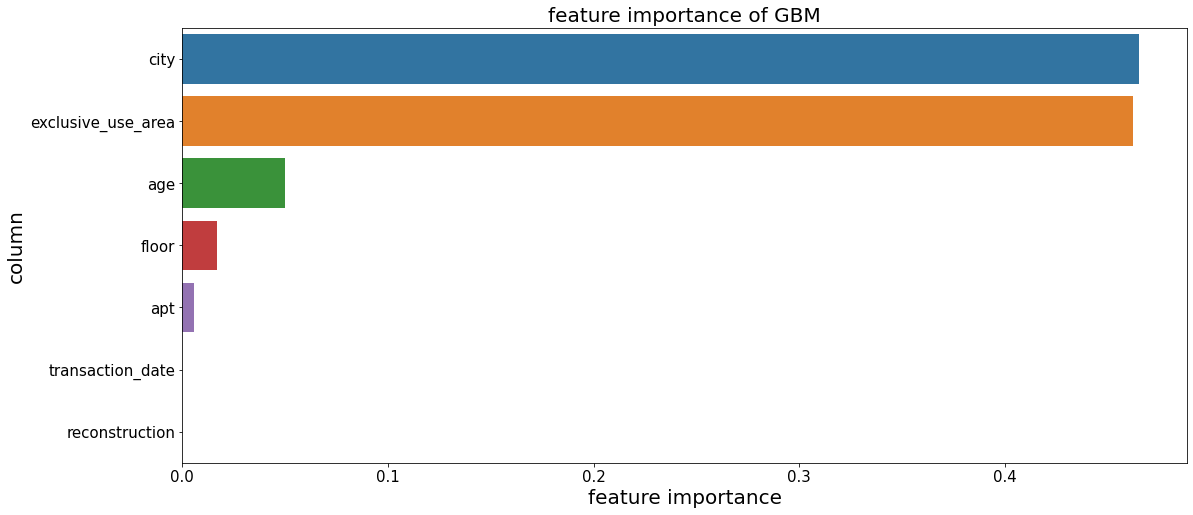

In [33]:
# seaborn의 barplot을 이용하여 변수의 중요도 순서대로 나타내봅시다.

plt.figure(figsize = (18,8))
sns.barplot(x ='feature importance', y =gbm_feature_importance.index ,orient='h', data = gbm_feature_importance)
plt.title('feature importance of GBM', size = 20)

plt.xticks(size = 15)
plt.yticks(size = 15)

plt.xlabel('feature importance', size = 20)
plt.ylabel('column', size = 20)
plt.show()

그런데 feature importance의 크기를 살펴보니, 아까 AdaBoost에서의 값들과 차이가 크네요! 

혹시 우리가 뭔가 잘못한 걸까요? 💦💦



아뇨! 절대 아닙니다. <br>
다행히도 이건 지극히 정상적인 결과입니다 😌😌



feature importance는 모델마다 값이 다른데요. 

그 이유는 모델마다 <font color=green>방법론</font>이 달라서, <font color=green>변수를 취급하는 정도</font>도 달라지기 때문입니다.

GBM 이후 GBM의 단점인 과적합, 느린 속도를 개선하고자 여러 파생 모델이 나왔는데요.

이들 중 일부는 GBM의 단점을 개선하면서 모델의 성능도 개선시켰어요! 👍️👍️👍️



그럼 다음 파트에서는 GBM의 파생 모델 중 하나인 **XGBoost**에 대해 알아볼까요?

---

## 3.4 XGBoost

<font color=red>**XGBoost**</font>는 `어떻게 하면 GBM이 더 빠르고 좋은 성능을 내게끔 만들 수 있을까?`로부터 고안된 방법론입니다. 

XGB의 특징은 다음과 같습니다.

* **<font color=orange>GBM에 비해 뛰어난 예측 성능</font>**

* **<font color=orange>GBM에 비해 짧은 수행 시간</font>**

* **<font color=orange>결측값 자체 처리 기능 존재</font>**

* **<font color=orange>나무 가지치기(Tree pruning)</font>**
    * **max_depth**라는 하이퍼파라미터가 존재하지만, 더 이상 긍정 이득이 없는 분할을 가지치기해서 분할 수 감소

* **<font color=orange>early stopping</font>**
    * 학습시킬 때 학습 횟수를 사전에 설정해줍니다. 이에, Early Stopping은 성능 개선(error 감소) 되고 있는지를 관찰하는 감시자 역할을 하게 됩니다.
    * 감시하다가 성능이 변화가 없거나 미미하다고 판단되면, 사전에 설정한 학습횟수에 도달하지 않았더라도 과적합되지 않도록 학습을 중단시킵니다.
    * XGB가 early stopping이 가능한 이유는 <font color=blue>내장된 자체 검증</font> 기능을 가지고 있기 때문입니다.

---

### XGBoost의 하이퍼파라미터

XGBoost에서도 자주 사용하는 하이퍼파라미터가 존재하는데요. 한번 알아보겠습니다!

* learning_rate : XGBoost가 학습을 진행 할 때마다 적용되는 학습률입니다. 기능은 Adaboost에서의 learning rate와 같습니다.

* n_estimators : 약한 학습기(weak learner)의 개수를 의미합니다. 기능은 Adaboost에서의 learning rate와 같습니다.

* max_depth : 트리의 최대 깊이를 지정해줍니다. 값이 클수록 학습 데이터를 잘 학습하지만 과대적합이 될 가능성이 생깁니다.

* subsample : 약한 학습기가 학습시 사용하는 데이터 샘플링의 비율을 의미합니다.

* colsample_bytree : 각 학습기별 feature의 샘플링 비율을 뜻합니다. 일반적으로 0.5 ~ 1 사이의 값을 선택합니다.

* early_stopping_round : 성능 변화가 없거나 미미하다 판단되면 사전에 설정한 학습횟수에 도달하지 않았더라도 과적합되지 않도록 학습을 중단시킵니다.

---

### XGBoost 실습

XGBoost 패키지에는 <font color=green>sklearn과 호환되지않는 XGBoost모듈</font>과 <font color=green>sklearn과 호환되는 XGBoost모듈</font>이 있어요.

호환을 위해 저희는 <font color=green>**sklearn과 호환되는 XGBoost 모듈**</font>을 사용해볼께요!

사이킷런과 호환되는 XGBoost 모듈에는 `XGBClassifier`와 `XGBRegressor`이 있습니다. 

우리는 <font color=orange>**XGBRegressor**</font>를 불러와서 실습을 진행하겠습니다.

In [34]:
from xgboost import XGBRegressor

C:\Users\USER\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


XGBRegressor는 사이킷런과 호환이 되기 때문에 사용법은 다른 모델들과 유사합니다.😌😌

기존의 다른 모델들 처럼 모델을 불러와 객체를 생성한 후, <font color=orange>**모델이름.fit(훈련할 x 변수, 훈련할 y 변수)**</font>를 기입해주면 학습을 진행하게 됩니다. 


이번 실습에서는 내장되어 있는 자체 검증을 통해 <font color=blue>early stopping</font>을 수행해볼게요!

모두 잘 따라올 준비 됐죠? 💟


자체 검증을 위해 내장되어 있는 자체 검증을 수행하려면 <font color=green>검증 데이터(validation data)</font>가 필요합니다.

이를 위해 train data를 다시 한 번 분할하겠습니다.

In [35]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train,test_size = 0.25, random_state = 42)

early stopping을 위해 필요한 파라미터는 다음과 같습니다

* **<font color=green>early_stopping_rounds</font>** : 평가 지표가 향상될 수 있는 반복 횟수를 정의
* **<font color=green>eval_metric</font>** : 조기 중단을 위한 평가 지표
* **<font color=green>eval_set</font>** : 성능 평가를 수행할 데이터


우리는 <font color=purple>**RMSE**</font>를 검증의 지표로 사용하겠습니다!

RMSE 값을 기준으로 값의 변화가 없거나 변화가 미미하면 학습을 종료하게 됩니다.
 


또한 <font color=purple>**early_stopping_rounds=50**</font>을 사용하여 50번 반복하는 동안, 성능평가 지표가 향상되지 않으면 학습은 멈추게 됩니다. <br>



<font color=purple>**eval_set**</font>에는 모델 내부에서 학습에 사용될 데이터와 평가에 사용될 데이터를 (x,y)쌍의 **리스트** 형태로 입력합니다.

In [36]:
xgb =  XGBRegressor(objective='reg:squarederror', random_state = 42)

In [37]:
model_xgb =  xgb.fit(X_tr, y_tr, eval_set =[(X_tr, y_tr), (X_val, y_val)], eval_metric = 'rmse', early_stopping_rounds=50)

C:\Users\USER\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-rmse:6.88661	validation_1-rmse:6.88851
[1]	validation_0-rmse:4.82742	validation_1-rmse:4.82915
[2]	validation_0-rmse:3.38853	validation_1-rmse:3.39012
[3]	validation_0-rmse:2.38487	validation_1-rmse:2.38640
[4]	validation_0-rmse:1.68734	validation_1-rmse:1.68882
[5]	validation_0-rmse:1.20575	validation_1-rmse:1.20709
[6]	validation_0-rmse:0.87769	validation_1-rmse:0.87888
[7]	validation_0-rmse:0.65918	validation_1-rmse:0.66025
[8]	validation_0-rmse:0.51926	validation_1-rmse:0.52015
[9]	validation_0-rmse:0.43382	validation_1-rmse:0.43454
[10]	validation_0-rmse:0.38469	validation_1-rmse:0.38522
[11]	validation_0-rmse:0.35780	validation_1-rmse:0.35822
[12]	validation_0-rmse:0.34330	validation_1-rmse:0.34360
[13]	validation_0-rmse:0.33532	validation_1-rmse:0.33555
[14]	validation_0-rmse:0.33129	validation_1-rmse:0.33143
[15]	validation_0-rmse:0.32880	validation_1-rmse:0.32896
[16]	validation_0-rmse:0.32678	validation_1-rmse:0.32687
[17]	validation_0-rmse:0.32586	validation

In [38]:
xgb_pred = model_xgb.predict(X_test)

In [39]:
print('XGB',RMSE(xgb_pred,y_test))

XGB 0.29701350932423176


결과를 보니 early stopping은 적용되지 않았고 RMSE 값은 약 0.3445가 나왔네요!💪

---

### XGBoost의 feature importance

XGBoost도 feature importance를 볼 수 있는데요. 방법은 위에서 했던 것과 완벽히 같습니다 😆

In [40]:
xgb.feature_importances_

array([9.9182233e-02, 1.9517016e-02, 2.4123408e-02, 8.4289724e-01,
       6.2664214e-04, 0.0000000e+00, 1.3653402e-02], dtype=float32)

XGBoost의 featue importance도 각각의 값은 X 컬럼과 순서대로 대응합니다. 

 `pd.DataFrame()`를 사용해서 데이터 프레임을 만들고 이를 사용해서 위에서처럼 가로로 된 barplot을 그려볼께요. 

(물론, 지금까지 barplot을 매우 많이 그려봤기 때문에, 여러분이 시시하다고 느끼실 수도 있을 것 같지만요 😥)

In [41]:
xgb_feature_importance = pd.DataFrame(xgb.feature_importances_, X.columns , columns =['feature importance'])

In [42]:
xgb_feature_importance

,feature importance
exclusive_use_area,0.099182
floor,0.019517
age,0.024123
city,0.842897
transaction_date,0.000627
reconstruction,0.000000
apt,0.013653


In [43]:
xgb_feature_importance = xgb_feature_importance.sort_values('feature importance', ascending = False)

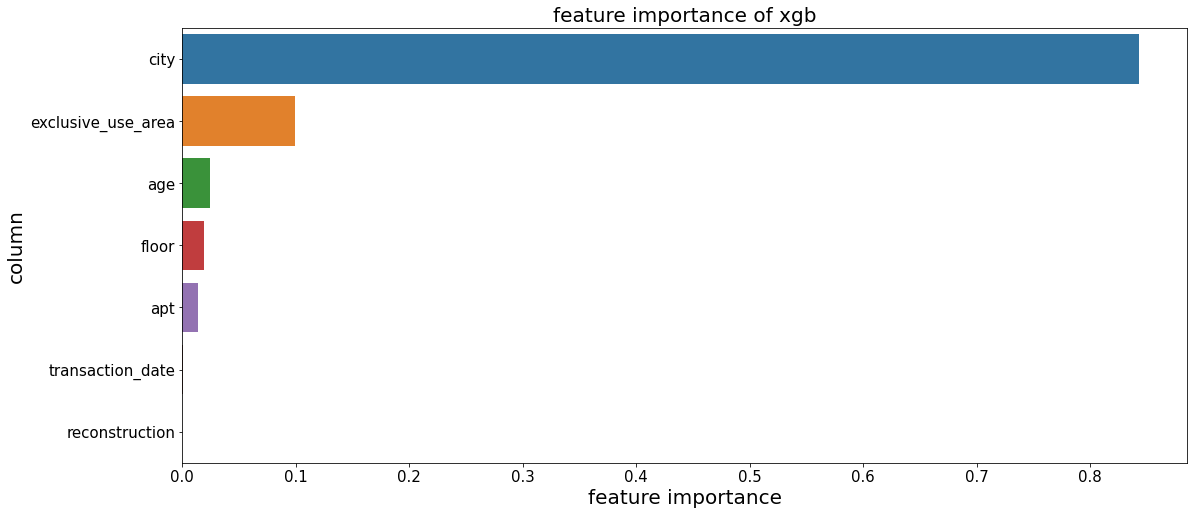

In [44]:
# seaborn의 barplot을 이용하여 변수의 중요도 순서대로 나타내봅시다.

plt.figure(figsize = (18,8))
sns.barplot(x ='feature importance', y =xgb_feature_importance.index ,orient='h', data = xgb_feature_importance)
plt.title('feature importance of xgb', size = 20)

plt.xticks(size = 15)
plt.yticks(size = 15)

plt.xlabel('feature importance', size = 20)
plt.ylabel('column', size = 20)
plt.show()

앞에서 언급했던것 처럼 모델마다 어떤 변수를 얼마나 중요하게 생각하는지는 다릅니다.

XGBoost는 exclusive_use_area보다 <font color=green>**city**</font>를 더 중요한 변수로 생각했네요!

---

## 3.5 Light GBM

다음으로 GBM의 또 다른 파생 모델인 Light GBM에 대해 알아보겠습니다. 

stage 5가 거의 다 끝나가니, 우리 조금만 더 힘내봐요! 💪💪

Light GBM은 XGBoost가 발표되고 나서, 2년 후에 발표되었는데요.

XGBoost의 단점을 보완한 모델입니다.

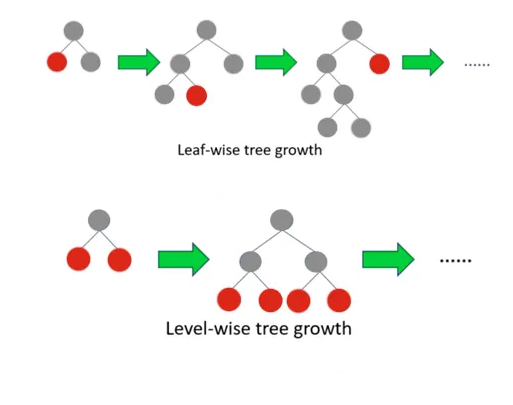

>출처 : https://medium.com/data-reply-it-datatech/lightgbm-for-timeseries-forecasting-408971289a12

<font color=red>**Light GBM**</font>은 <font color=green>**트리 성장 방식**</font>에서 다른 GBM 계열과 다른 방식을 사용합니다.

일반적인 GBM계열은 균형 트리 분할(Level-wise)방식을 통해 트리를 분할하면서 성장합니다. 이는 트리를 수평적으로 키운다는 뜻입니다.<br> 
이를 통해 트리의 깊이를 최소화하고 과적합도 방지할 수 있습니다. <br>
하지만 트리를 균형적으로 만들기 위한 추가 연산이 필요하기 때문에 상대적으로 속도가 느립니다

반면, Light GBM은 <font color=blue>**리프 중심 트리 분할(Leaf-wise)**</font>방식을 통해 트리를 분할하면서 성장합니다. <br>
이는 성능을 가장 낮추는(loss가 가장 큰) 가지만 선택해 loss를 줄여나가는 방식입니다.<br>
그렇기 때문에, 위 그림에서 볼 수 있듯이 불균형하게 성장하죠.

따라서 Light GBM은 리프 중심 트리 분할방식을 통해 <font color=green>예측 오류를 최소화</font>할 수 있습니다. <br>
또한, 균형 유지를 위한 추가 연산이 필요하지 않기 때문에 상대적으로 속도가 빠릅니다.

Light GBM의 특성을 요약하면 다음과 같습니다.

* **<font color=orange>짧은 학습 시간</font>**

* **<font color=orange>적은 메모리 사용량</font>**

* **<font color=orange>Categorical Feature들을 자동변환 및 이에 따른 노드 분할 수행</font>**

* **<font color=orange>GPU를 이용한 학습 지원</font>**

* **<font color=orange>과적합 발생 가능성 존재</font>**
    * 따라서 Light GBM은 **대용량 데이터**에서 보다 바람직함

---

### Light GBM의 하이퍼파라미터

이제 Light GBM의 주요 파라미터에 대해 알아보겠습니다.

- max_depth : 트리의 최대 깊이를 조절합니다. Light GBM의 경우 leaf-wise이기 때문에 적절한 max_depth의 조절이 과적합을 막을 수 있습니다.

- n_estimators : 약한 학습기의 개수를 의미합니다.

- early_stopping_round : 성능 변화가 없거나 미미하다 판단되면 사전에 설정한 학습횟수에 도달하지 않았더라도 과적합되지 않도록 학습을 중단시킵니다.

- learning_rate : Light GBM이 학습을 진행 할 때마다 적용되는 학습률입니다. 기능은 여타 다른 부스팅 모델들에서의 learning rate와 같습니다.

- subsample_for_bin : 최적 분할 지점 탐색에 사용되는 하나의 간격에 대한 크기입니다.

* colsample_bytree : 각 학습기마다 feature의 샘플링 비율을 뜻합니다. 일반적으로 0.5~ 1 사이의 값을 선택합니다.

---

### Light GBM 실습

Light GBM 패키지에는 <font color=green>sklearn과 호환되지않는 Light GBM모듈</font>과 <font color=green>sklearn과 호환되는 Light GBM모듈</font>이 있어요.

호환을 위해 저희는 <font color=green>**sklearn과 호환되는 LightGBM 모듈**</font>을 사용하여 <font color=orange>**LGBMRegressor**</font>를 불러와서 실습을 진행하겠습니다.

먼저 LGBMRegressor을 통해 하이퍼 파라미터를 default 값으로 갖는 모델을 불러와 **lgb**라는 객체에 저장합니다.

In [45]:
from lightgbm import LGBMRegressor

In [46]:
lgb = LGBMRegressor(random_state = 42)

이후 <font color=green>모델이름.fit(훈련할 독립변수, 훈련할 종속변수)</font>를 기입해주면 학습을 진행하게 됩니다. 



이번 실습에도 내장되어 있는 자체 검증을 통해 early stopping을 수행해볼 건데요!

여러분이 복습하실 수 있게끔 퀴즈로 준비해봤습니다 ✅✅

---

#### 퀴즈

In [ ]:
# light gbm에서 자체검증을 사용하여 모델학습을 수행해주세요.

model_lgb =  lgb.fit(####코드를 채워 주세요####)

##### 설명

early stopping이 50, 평가지표는 rmse인 자체 검증을 실시해주세요.
(단, 검증 데이터는 기존에 생성한 X_val,  y_val 데이터를 사용해주세요.)

##### 풀이-힌트

early stopping을 위해 필요한 파라미터는 XGB에서와 유사하고, 사용법 또한 유사합니다. 아래의 설명을 참고해서 작성해주세요.

* **<font color=green>early_stopping_rounds</font>** : 평가 지표가 향상될 수 있는 반복 횟수를 정의
* **<font color=green>eval_metric</font>** : 조기 중단을 위한 평가 지표
* **<font color=green>eval_set</font>** : 성능 평가를 수행할 데이터


##### 풀이-정답

```
#light gbm에서 자체검증을 사용하여 모델학습을 수행해주세요.

model_lgb =  lgb.fit(X_tr, y_tr, eval_set =[(X_tr, y_tr), (X_val, y_val)], eval_metric = 'rmse', early_stopping_rounds=50)
```

---

여러분, 퀴즈 잘 풀어 보셨나요? 👏👏👏

이제 test 데이터를 통해 모델의 성능을 측정해볼게요!

In [48]:
lgb_pred = model_lgb.predict(X_test)

In [49]:
print('LGB',RMSE(lgb_pred,y_test))

LGB 0.3234525519060052


RMSE가 약 0.323이 나왔네요! 확실히 GBM에 비해 성능이 개선된 것 같아요 💜

---

### Light GBM의 feature importance

Light GBM도 <font color=orange>**fit된 모델.feature_importances_**</font>를 통해 feature importance를 볼 수 있답니다!

In [50]:
lgb.feature_importances_

array([1220,  287,  810,  142,    8,    0,  533])

사용법은 다른 모델들과 동일하니, 바로 실습해봅시다!

In [51]:
lgb_feature_importance = pd.DataFrame(lgb.feature_importances_, X.columns , columns =['feature importance'])

In [52]:
lgb_feature_importance

,feature importance
exclusive_use_area,1220
floor,287
age,810
city,142
transaction_date,8
reconstruction,0
apt,533


In [53]:
lgb_feature_importance = lgb_feature_importance.sort_values('feature importance', ascending = False)

feature importance 그래프를 그리는 방법을 반복적으로 적용해보면서, 이번 기회에 제대로 익혀봅시다 ✍✍

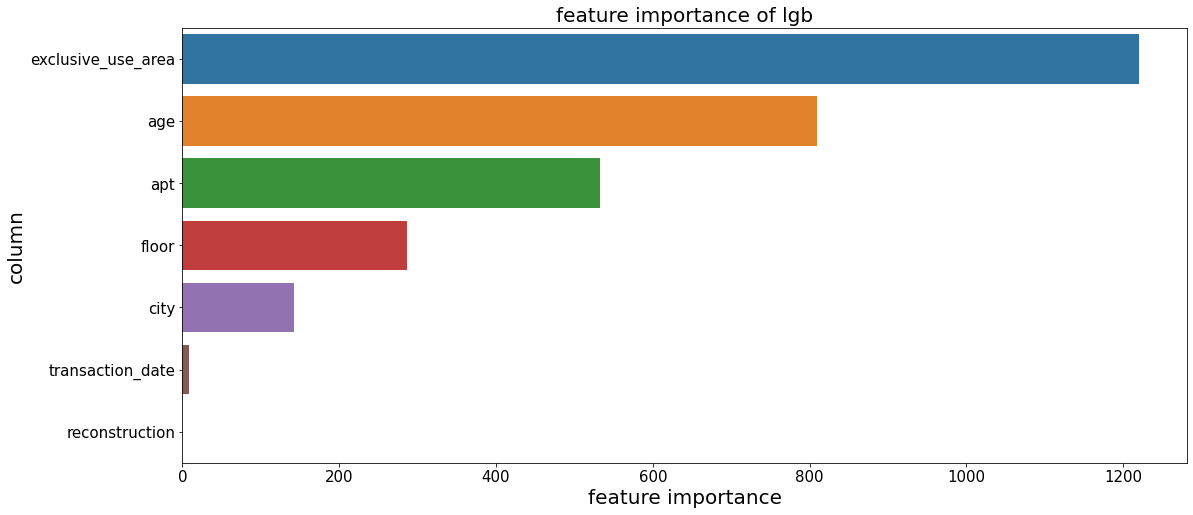

In [54]:
# seaborn의 barplot을 이용하여 변수의 중요도 순서대로 나타내봅시다.

plt.figure(figsize = (18,8))
sns.barplot(x ='feature importance', y =lgb_feature_importance.index ,orient='h', data = lgb_feature_importance)
plt.title('feature importance of lgb', size = 20)

plt.xticks(size = 15)
plt.yticks(size = 15)

plt.xlabel('feature importance', size = 20)
plt.ylabel('column', size = 20)
plt.show()

---

# 4. 모델 선택

지금까지 4가지 부스팅 계열의 모델에 대해 배웠습니다! 모두 고생하셨어요😂😂 


그렇다면 이것들 중 우리는 어떤 모델을 선택해야할까요? 

모델을 선택할 때는, 모델의 <font color=blue>**성능**</font>과 <font color=blue>**시간**</font>을 모두 고려하는 게 좋습니다! 

그러면 우선 부스팅 계열 모델들의 성능 비교를 해보겠습니다.

비교를 위해 일부 하이퍼 파라미터는 통일(n_estimators = 100)하고, 나머지는 모두 default 값을 사용하겠습니다.

|모델|RMSE|시간|
|------|---|---|
|Adaboost|0.3822|56초|
|GBM|0.345|86초|
|XGB|0.3445|57초|
|lightGBM|0.3235|6.4초|

결과를 보니, <font color=green>**Light GBM**</font>의 성능이 가장 좋으면서 수행시간도 빠르고, 반면 Adaboost는 성능이 썩 좋지 않네요! 

또한 GBM과 XGBoost은 상대적으로 속도가 느린 편에 속하네요 😥 

이처럼 모델의 성능과 속도를 보고, 어떤 모델이 우수한지 판단할 수 있습니다.

Stage 5에서는 여러 부스팅 계열의 모델에 대해 배워봤는데요.

그러니 우리는 이제 다음과 같은 대화를 나눌 수 있게 된 거에요!

👩(누군가): `너, 부스팅 모델이 뭔지 아니?` <br>
👦(데이커 여러분): `나, 최근에 부스팅 계열 모델에 대해 열심히 배웠기 때문에 잘 알고 있어!`

그런데, stage 5가 벌써 끝이냐구요?  

👨‍🏫(한남더힐 팀원들): `에이, 설마요! 그렇지 않습니다!!!!`



지금까지 열심히 공부하신 여러분들을 위해 보너스 심화 과정을 준비했습니다! 소리질러! 📢📢📢<br>



이번 Stage 5에서는 심화 과정을 무려 2개나 준비했는데요! 다들 더 배워볼 준비 되셨나요? 💪💪


---

# 심화1 CatBoost

첫 번째는 바로 부스팅 계열 모델의 인기쟁이 <font color=red>Catboost</font>입니다!

다들 궁금하시죠? 자세히~ 준비했으니 저희만 믿고 따라오세요!

여러분 혹시 CatBoost 이름의 기원을 아시나요?😶  




Cat라는 이름은 <font color=green>Category</font>에서 왔습니다. 즉, CatBoost는 <font color=green>**범주형 변수**</font>가 많은 데이터셋에 적합하도록 발전된 부스팅 모델입니다.



CatBoost의 특징은 크게 다음과 같습니다.

1. **<font color=orange>Ordered Boosting</font>**
2. **<font color=orange>Ordered Target Encoding</font>**
3. **<font color=orange>Categorical Feauture Combinations</font>**


먼저 Ordered Boosting 방법부터 봅시다 !





GBM 기반의 기존 모델들은 학습데이터의 <font color=green>전체 잔차</font>를 계산한 후 약한 학습기들이 이를 개선시키는 방향으로 학습이 진행되었습니다.<br> 



반면, Catboost는 학습데이터의 <font color=red>일부만으로 잔차 계산</font>을 하고, 또 새로운 부스팅 모델을 만들어 다시 일부 데이터를 학습하는 방식입니다.<br> 



데이터의 일부를 선택하는 방식은 **랜덤**하게 선택되며, 이를 통해서 **과적합**을 방지합니다.<br> 

 이러한 방식의 학습 방법을 **<font color=orange>Ordered Boosting</font>** 이라고 합니다.

Catboost는 범주형 변수를 처리하는 방식에서도 기존 모델들과는 다르게 <font color=orange>Ordered Target Encoding</font>라는 독특한 방법을 사용합니다. 

해당 방법의 핵심은 범주형 변수를 인코딩할 때 y값, 즉 <font color=blue>**종속변수**</font>를 참고한다는 것인데요.

예시를 한번 보자구요.

|시간|날씨|온도(target)|
|------|---|---|
|1일|맑음|35|
2일|맑음|37|
|3일|흐림|20|
|4일|맑음|38|
|5일|흐림|18|
|6일|번개|10|
|7일|비|12|
|8일|비|13|
|9일|번개|8|
|10일|비|8|
|11일|비|10|

예를 들어 날씨 데이터에서 날씨는 우리가 인코딩해야 할 범주형 변수, 온도는 우리가 알고 싶은 target 값이라고 가정하겠습니다. 

이때 우리는 날씨 범주를 숫자로 변환하기 위해서 target인 온도 변수의 <font color=purple>평균값</font>을 이용합니다.

맑음 = $\frac{35+37+38}{3}$ = 36.67

흐림 = $\frac{20+18}{2}$ = 19

번개 = $\frac{10+8}{2}$ = 9

비 = $\frac{12+13+8+10}{4}$ = 10.75


즉, 맑음, 흐림, 번개, 비에 속하는 데이터들 각각의 target 값 평균을 인코딩 값으로 사용하는 것입니다. 

그래서 <font color=blue>Mean Encoding</font>이라고 불리기도 합니다.

⚠️ 하지만 이때 주의해야 할 점이 있습니다! ⚠️



우리가 예측해야 할 target 값이 훈련 데이터의 피처에 들어가는 문제가 생기게 됩니다. 

정답을 가지고 학습을 해버리는 꼴이 되버리는 거죠😫

 CatBoost는 이러한 문제점을 해결하기 위해 <font color=green>해당 범주에 해당하는 과거의 target값만 모아서 평균을 계산해 인코딩</font>합니다.

 예를 들어 다음과 같습니다.

8일에는, 비 = 12 로 인코딩

10일에는, 비 = $\frac{12+13}{2}$ = 12.5 로 인코딩

11일에는, 비 = $\frac{12+13+8}{3}$ = 11  로 인코딩


참 똑똑하지 않나요?😀

하지만, Catboost가 범주형 변수를 항상 Ordered Target Encoding을 하는 것은 아닙니다. 

Catboost는 범주의 개수가 적은 범주형 변수에 대해서는 One-hot Encoding을 수행합니다. <br>
범주의 개수 기준은 <font color=purple>one_hot_max_size</font> 파라미터로 설정하게 됩니다.

예를 들어 one_hot_max_size = 3 으로 준 경우, <br>
범주의 개수가 3개 이하인 범주형 변수들은 Target Encoding 이 아니라 One-hot Encoding을 하게 됩니다.

즉 catboost는 범주형 변수를 처리할 때  **Ordered Target Encoding**과 **One-Hot Encoding**을 혼용해서 사용합니다.

마지막으로 catboost는 학습 과정에서 information gain이 비슷한 feature를 자동으로 하나의 feature로 조합합니다.

 이를 <font color=green>Categorical Feauture Combinations</font>이라고 합니다.

이번에도 예시를 준비했습니다 🤩

|나라|머리색|class label|
|------|---|---|
|인도|검정|1|
|인도|검정|1|
|인도|검정|1|
|인도|검정|1|
|노르웨이|노랑|0|
|노르웨이|노랑|0|
|노르웨이|노랑|0|
|노르웨이|노랑|0|


위의 테이블에서 class label을 구분한다고 할 때, 여러분이라면 어떤 칼럼을 사용할 것 같나요? 나라? 아니면 머리색? ⚖️

아니면 혹시, 제 질문이 좀 이상하게 느껴지진 않나요? 😎
 

왜냐면 <font color=blue>둘 중 아무거나 사용해도 되기 때문</font>입니다.
 
 


이는 나라 컬럼, 머리색 컬럼 모두 class label을 구분하는데 <font color=green>동일한 정보</font>를 제공하기 때문입니다. 



즉, 두 칼럼의 information gain은 <font color=green>동일</font>해요! 

따라서 이러한 변수들이 존재할 때 Catboost는 <font color=blue>하나의 변수로 통합</font>함으로써 연산 비용을 줄이게 됩니다. (고놈 참 똑똑하네! 😮😮)

이제 여러분들이 기다렸던 CatBoost 실습 시간이 되었습니다!

CatBoost 에는 `CatBoostClassifier`와 `CatBoostRegressor`이 있습니다. 

다른 모델들과 마찬가지로 분류의 경우 `CatBoostClassifier`, 회귀의 경우 `CatBoostRegressor`를 사용하게 됩니다. 

저희는 <font color=orange>**CatBoostRegressor**</font>를 불러와서 실습을 진행하겠습니다.



```
from catboost import CatBoostRegressor
```



CatBoost는 범주형 변수가 많은 데이터에 특화된 모델이라고 했죠? 



때문에 Catboost에는 <font color=orange>**cat_features**</font>라는 범주형 변수를 지정하는 요소가 있습니다.

여기에 범주형 변수를 입력하게 됩니다.

 또한 <font color=orange>**one_hot_max_size**</font>를 통해 One-Hot Encoding할 범주의 최대수를 지정하게 됩니다. 

이 두 요소를 통해 Catboost는 범주형 변수에 대해 **Ordered Target Encoding**과 **One-Hot Encoding**을 수행하게 됩니다.

이를 위해 범주형 변수를 먼저 지정하겠습니다.

```
cat_f = ['city', 'transaction_date', 'reconstruction']
```



해당 데이터에서는 범주의 수가 각각 2개, 3개, 2개로 범주의 수가 많지 않네요.

그래서 <font color=green>**one_hot_max_size = 3**</font>을 지정하면 모든 범주형 변수에 대해 one-hot encoding을 수행하게 됩니다!

이후의 학습 과정은 다른 부스팅 계열의 모델들과 동일합니다.



```
cbr =  CatBoostRegressor(n_estimators = 100,random_state = 42, cat_features = cat_f, one_hot_max_size = 3 , eval_metric = 'RMSE')
model_cbr =  cbr.fit(X_tr, y_tr, eval_set =[(X_tr, y_tr), (X_val, y_val)] ,early_stopping_rounds=50)
cbr_pred = model_cbr.predict(X_test)
print('cbr',RMSE(cbr_pred,y_test))
```



image.png

RMSE가 0.3187로 낮게 나왔네요!

첫번째 심화 과정 잘 배우셨나요? 이제 catboost가 왜 인기쟁이인지 아시겠지요?😆

숨 가쁘게 달려온 데이커 여러분들께 박수를 보냅니다 👏👏

이제 마지막 과정 하나만 남아 있습니다! 너무 아쉬우시다구요?

하하, 그래서 두 번째 심화과정도 열심히 준비했으니 마지막까지 함께 하기로 약속! 약속! 🤙🤙

---

# 심화2 Pycaret

저희가 준비한 심화 과정 두 번째는 모델 선정의 길잡이 역할을 해주는 <font color=red>Pycaret</font>입니다! 

자! 그럼 시작합니다~ 🚗

여러분, 우리는 stage 4, 5에 걸쳐서 여러 모델을 살펴봤는데요. <br>
그런데 어떤 모델을 선택할 것인가를 결정할 때 매번 이렇게 모델들을 하나씩 구현한 후 성능을 비교해야 할까요?

더 효율적인 방법은 없을까요? 🤔

이런 상황에서, 모델 선택을 편리하게 해주는 Pycaret을 사용할 수 있습니다!

<font color=red>**Pycaret**</font>이란 머신러닝 워크플로우를 자동화한 오픈소스 라이브러리입니다. 

즉, 분류나 회귀문제에서 사용하는 여러 모델들을 동일한 환경에서 쉽게 구현하도록 **자동화한 라이브러리**입니다.

(와~ 자동이라니! 너무 편리한거 아닌가요?😆)

Pycaret을 사용하면 코드 몇 줄만으로 여러 모델을 비교할 수 있기 때문에, 모델 선정 과정에서 길잡이 역할을 해줍니다. 

이제 Pycaret을 통해 우리가 보유한 데이터에는 어떤 모델이 적합한지 알아볼게요!

그리고 우리는 회귀문제를 풀고 있기 때문에 <font color=orange>from pycaret.regression import</font>를 통해 regression과 관련된 것들을 불러옵니다. 

여기서 **<font color=blue>*</font>**는 관련된 모든 걸 불러온다는 뜻입니다.



```
from pycaret.regression import *
```



이후 <font color=orange>setup()</font>함수를 통해 전체적인 머신러닝 틀을 짜게 됩니다. 여기에 사용되는 대표적인 인자들은 다음과 같습니다.

* data : 머신러닝에 사용할 데이터
* target : 우리가 예측하고자 하는 칼럼(종속 변수)
* categorical_features : 범주형 변수들의 이름 
* numeric_features : 수치형 변수들의 이름
* train_size : train, test 데이터의 비율
* normalize : 수치형 변수들의 scaling 유무
* normalize_method  : scaling 방법
* session_id : 랜덤시드값 고정

❗❗ 여기서 중요한 점 하나를 짚고 넘어갑시다  ❗❗ 

data 요소에 들어가는 데이터는 <font color=blue>**y**</font> 까지 포함되어야 해요. 

그래서 분석에 사용할 <font color=blue>**X와 y**</font>를 합쳐서 하나의 데이터로 만들어야 합니다!



```
full_train = pd.concat([X, y], axis=1)
```



다음으로 범주형 변수들의 이름, 수치형 변수들의 이름을 리스트 형태로 만들겠습니다.



```
categorical_features = ['city','transaction_date', 'reconstruction']
numeric_features = ['exclusive_use_area','floor', 'age', 'apt']
```



이제 train 데이터와 test 데이터의 비율을 8대 2으로 하여 머신러닝 틀을 짜볼게요!



```
from pycaret.regression import *

reg = setup(data = full_train, 
            target = 'transaction_real_price', 
            categorical_features = categorical_features,
            numeric_features = numeric_features,
            train_size = 0.8, 
            normalize = True,
            normalize_method = 'minmax',
            session_id = 42)
```



다음으로  <font color=orange>compare_models</font>들을 통해 여러 모델들을 구축한 후 성능을 비교할 수 있습니다.

여기서 사용되는 대표적인 인자는 다음과 같습니다.

* fold : cross validation을 수행할 때의 폴드 수
* n_select : 출력할 모델의 수
* sort : 모델들을 나열할 때 기준이 되는 성능 평가 척도
* include : 내가 비교하고 싶은 모델들 (만약 include를 사용하지 않으면, 내장되어 있는 모든 모델들을 비교해요 😃)

우리가 그동안 공부했던 모델들을 include에 넣고 성능 비교를 해봅시다 🧡



```
models = compare_models(fold = 5, sort = 'RMSE', n_select = 6, include = ['rf', 'lr', 'ada', 'gbr', 'xgboost','lightgbm'])
```



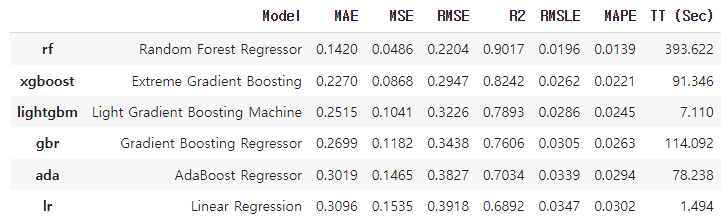

RMSE를 기준으로 <font color=purple>**RandomForest**</font>가 가장 성능이 좋고 XGBoost, LightGBM 순으로 성능이 우수하게 나왔네요!

어! 그런데 조금 이상하네요 😓 <br>
앞에서 하나씩 출력했을 때의 결과를 기억하시나요? 왜 Pycaret에서는 다른 결과가 나왔을까요?

Pycaret은 <font color=green>**cross-validation**</font>을 통해 <font color=green>평균적인 성능</font>을 측정했기 때문입니다. (아~ 그렇구나!😀)

그런데 잠깐만요 ✋✋

⚠️⚠️ 오해하기 없기! ⚠️⚠️ 



그렇다고 해서, 위에 나온 결과가 <font color=green>**절대적인 결과는 아니랍니다.</font>** 

모델들은 <font color=green>하이퍼 파라미터</font>에 따라 성능이 크게 달라지기 때문이에요!

그렇기 때문에 Pycaret을 통해 모델을 비교할 때에는 성능이 가장 좋은 모델을 선택하는 것이 아니라, <br>
여러 모델들 중 <font color=blue>**최종 모델의 후보에서 탈락시키는 일**</font>을 해야 합니다.

위에서 나왔던 결과와 Pycaret 모두 AdaBoost가 부스팅 계열의 모델들 중 가장 성능이 안 좋기 때문에 <font color=purple>**AdaBoost는 모델 후보에서 제외**</font>합니다!

또한 그보다 성능이 더 안 좋은 <font color=purple>**Linear Regression 모델도 최종 후보에서 제외**</font>하겠습니다!✂️✂️ 

다음으로 Gradient Boosting Regressor은 속도도 느리면서 성능도 좋지 않습니다. <br>
따라서 **Gradient Boosting Regressor 또한 최종 후보에서 제외**하겠습니다.✂️✂️  

이제 앞에서 진행했던 과정과 Pycaret 결과를 종합하여 **<font color=red>RandomForest</font>**, **<font color=red>XGBoost</font>**, <font color=red>**Light GBM**</font>을 최종 후보로 선정하겠습니다.

---

# 4. 결론

앞에서 언급한 것처럼 모델은 하이퍼 파라미터 값에 따라 성능이 크게 달라집니다. 

그래서 하이퍼 파라미터 튜닝 과정이 필요한 것인데요. 

우리는 Stage 6에서 최종 후보들의 하이퍼 파라미터 튜닝 과정을 통해 최적의 모델을 선정해보겠습니다!



그럼 모두 Stage 6에서 만나요~😉

---